# Deep Variational Symmetric Information Bottleneck (DVSIB)

This notebook implements the DVSIB method as described in the paper: "Deep Variational Multivariate Information Bottleneck - A Framework for Variational Losses."

**Authors:** 
- Eslam Abdelaleem ([Email](mailto:eslam.abdelaleem@emory.edu))
- K. Michael Martini ([Email](mailto:karl.michael.martini@emory.edu))

**License:** 
- [MIT License](link-to-license-file)

**Version History:**
- **v1.0 (6 October 2023):** Initial release.

**Dependencies:**
- Python
- PyTorch
- NumPy
- Matplotlib
- Scikit-learn

## Usage Instructions:

1. Execute the code cells sequentially to run the notebook.
2. The notebook uses a custom Noisy MNIST dataset (details in the paper). Generate the data by executing the DVMIB-Data Generation.ipynb notebook.
3. The first section loads and preprocesses the dataset, including splitting it into training, validation, and test sets, and visualizing the data.
4. The second section defines the DVSIB model, performs training, and visualizes the embeddings using t-SNE.
5. The third section assesses the quality of classifications using Linear SVM and Neural Networks.

For questions, issues, or support, please visit our [Issue Tracker](link-to-issues) or contact us via email.

Happy experimenting with DVSIB!


In [1]:
# Import libraries, the code is built on PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
import sys
import os

# Import the classifier related functions
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Dataset

# Those functions if we generate or augment the data here as well
#from torchvision import transforms
#from torchvision.datasets import MNIST
# from noise import pnoise2
# from itertools import groupby


warnings.filterwarnings("ignore")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 140

In [7]:
# Check if CUDA is running
device = 'cuda'
if(not torch.cuda.is_available()):
    device = 'cpu'
print(device)

cuda


# Part 1: Loading and Splitting the Noisy MNIST Dataset
In this section, we load a custom version of the Noisy MNIST dataset, which is used as the basis for our experiments. The dataset is preprocessed to ensure it's suitable for dimensionality reduction tasks. To follow along, execute the code cells sequentially, skipping all cells except the last one if you wish to load a different dataset.

In [9]:
# Load the data dictionary from the file: data.npz
loaded_data = np.load('data.npz', allow_pickle=True)

# Assign datasets to variables that correspond to:
# training: tr, test: ts, validatoin: val
# Which view of the data: _X and _Y
# true labels: _labels, rotaion: _theta, scaling factor: _scale, Noise factor used to generate Perlin background noise: _noise

tr_X = loaded_data['train_X']
tr_Y = loaded_data['train_Y']
tr_labels = loaded_data['train_labels']
tr_theta = loaded_data['train_theta']
tr_scale = loaded_data['train_scale']
tr_noise = loaded_data['train_noise']

ts_X = loaded_data['test_X']
ts_Y = loaded_data['test_Y']
ts_labels = loaded_data['test_labels']
ts_theta = loaded_data['test_theta']
ts_scale = loaded_data['test_scale']
ts_noise = loaded_data['test_noise']

val_X = loaded_data['validation_X']
val_Y = loaded_data['validation_Y']
val_labels = loaded_data['validation_labels']
val_theta = loaded_data['validation_theta']
val_scale = loaded_data['validation_scale']
val_noise = loaded_data['validation_noise']

# Load the pre shuffeled params dictionary from the file: noisy_params.npz
loaded_data_params = np.load('noisy_params.npz', allow_pickle=True)

# Assign datasets to variables
theta = loaded_data_params['theta']
scales = loaded_data_params['scales']
noise_factor = loaded_data_params['noise_factor']

In [10]:
# Create a function to plot X and Y pairs side by side
def plot_samples(dataset_X, dataset_Y, label, num_samples=5):
    plt.figure(figsize=(num_samples*3, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset_X) - 1)
        x = dataset_X[idx]
        y = dataset_Y[idx]

        x_np = x.reshape(28,28)
        y_np = y.reshape(28,28)

        plt.subplot(2, num_samples, i + 1)
        plt.title('True = '+str(label[idx])+', Corr = '+str(np.round(np.corrcoef(x.reshape(28*28),y.reshape(28*28))[0][1],2)))
        plt.imshow(x_np.reshape(28,28), cmap="gray")
        plt.axis("off")

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(y_np.reshape(28,28), cmap="gray")
        plt.axis("off")

    plt.show()

In [11]:
# Create a function to plot X and Y pairs side by side for ordered numbers
def plot_samples1(dataset_X, dataset_Y, label, save_name, num_samples=5, rnd=0):
    id_lst = np.zeros(10)
    for j in range(10):
        id_lst[j] = np.where(label==j)[0][rnd]
        
    plt.figure(figsize=(num_samples*3, 5))
    for i in range(num_samples):
        idx = int(id_lst[i])
        x = dataset_X[idx]
        y = dataset_Y[idx]

        x_np = x.reshape(28,28)
        y_np = y.reshape(28,28)

        plt.subplot(2, num_samples, i + 1)
        #plt.title('True = '+str(label[idx])+', Corr = '+str(np.round(np.corrcoef(x.reshape(28*28),y.reshape(28*28))[0][1],2)))
        plt.imshow(x_np.reshape(28,28), cmap="gray")
        plt.axis("off")

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(y_np.reshape(28,28), cmap="gray")
        plt.axis("off")
#     plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.show()

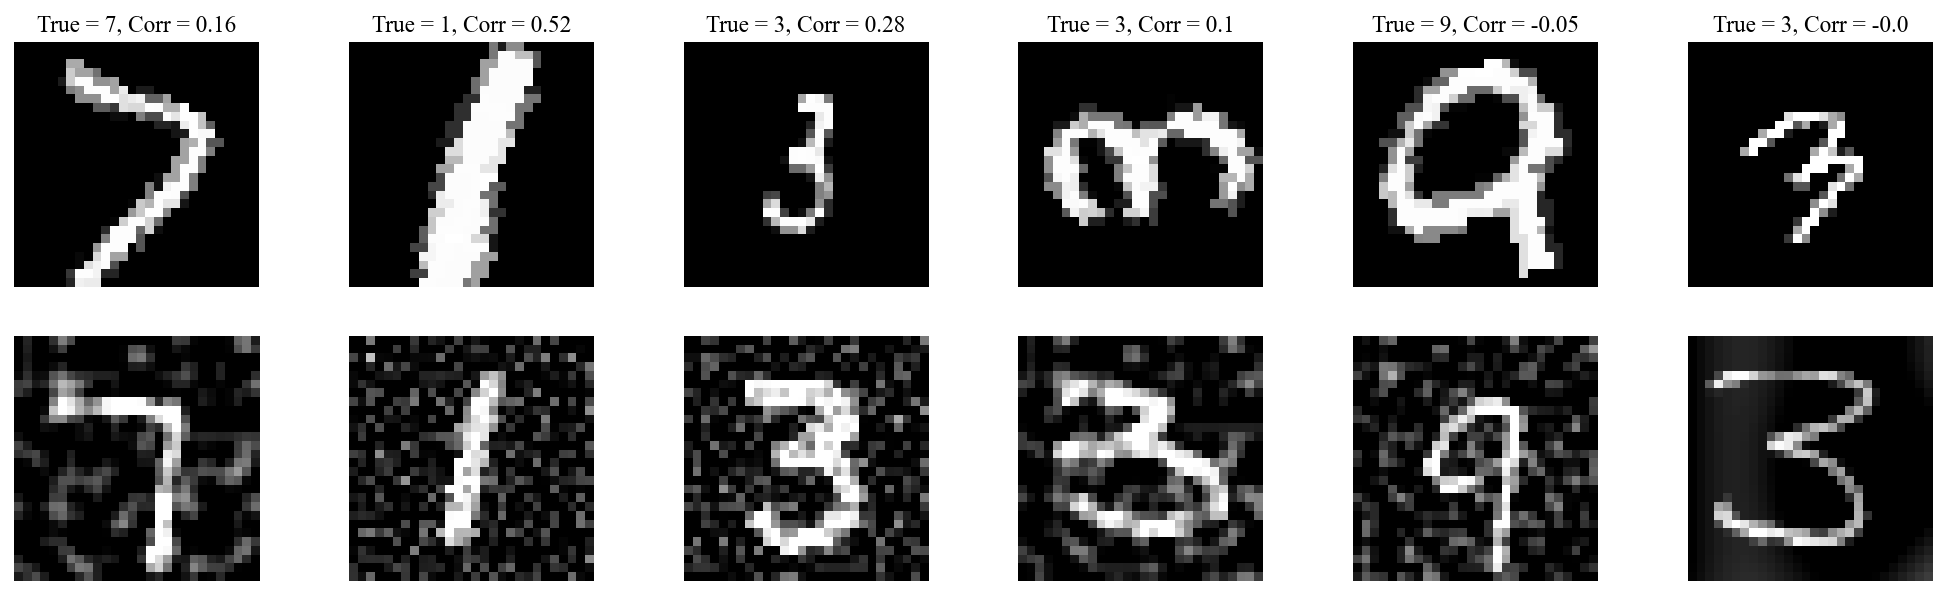

In [12]:
# Plot a few instances of X and Y pairs side by side
plot_samples(tr_X, tr_Y, tr_labels, 6)

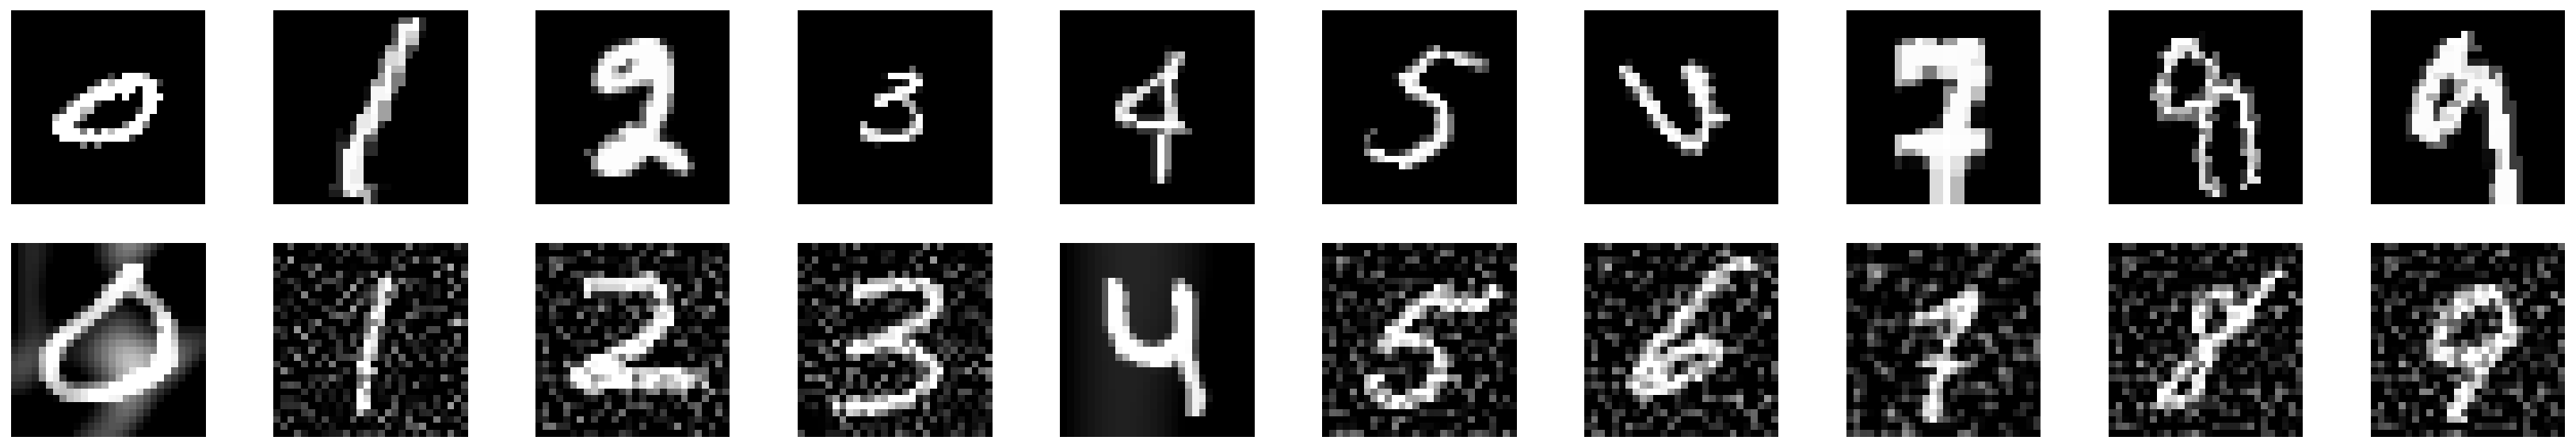

In [16]:
# Plot the 10 numbers
plot_samples1(tr_X, tr_Y, tr_labels, _, 10)

In [6]:
# Make into a dataloader so we can use it in the training
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, Y):
        self.X = X
        self.Y = Y

  def __len__(self):
        return len(self.X)

  def __getitem__(self, index):
        return self.X[index], self.Y[index]

data_train = torch.utils.data.DataLoader(Dataset(tr_X,tr_Y),
        batch_size=128,
        shuffle=True)


# Get the number of dimensions to be used in the networks
input_dim_x = tr_X[0].shape[-1]
input_dim_y = tr_Y[0].shape[-1]

# Part 2: DVSIB Impelementation

In this section, we walk you through the implementation of the Deep Variational Symmetric Information Bottleneck (DVSIB) method. This includes several key components:

**Encoder:** We define an encoder that transforms the input data from its original dimensionality to a lower-dimensional space ($Z_X$ and $Z_Y$).

**Decoder:** We set up a decoder that reconstructs the data from the lower-dimensional space back to the original dimensionality.

**Decoder MINE:** We define a decoder for the Mutual Information Neural Estimation (MINE) component to estimate the mutual information between $Z_X$ and $Z_Y$.

**DVSIB Module:** This module orchestrates the entire DVSIB process. It invokes the encoder, decoder, and decoder MINE as needed, calculates the loss functions for both the encoder and decoder graphs, and combines them using the tradeoff parameter ($\beta$).

**Training Function:** We provide a function for training the DVSIB module using your dataset. You can specify the dimensions of the latent spaces ($Z_X$ and $Z_Y$) and the tradeoff parameter ($\beta$).

**Instantiating and Training:** We instantiate the DVSIB module and train it using your data. You can customize the dimensions of the latent spaces ($Z_X$ and $Z_Y$) and the tradeoff parameter ($\beta$) as needed.

**Embeddings:** We obtain embeddings by passing the data (training, testing, and validation) through the encoder to create low-dimensional representations. We also provide steps to detach these embeddings from the GPU for further analysis.

**Visualization with t-SNE:** We visualize the obtained embeddings using t-SNE to gain insights into the data's low-dimensional structure.

**Reconstruction:** To evaluate the quality of the model, we pass the embeddings through the decoder to generate new samples. These reconstructed images can help visualize the performance of the DVSIB model.

By following the steps in this section, you'll gain a comprehensive understanding of how to implement, train, and evaluate the DVSIB method for your specific dataset.

In [7]:
# Encoder of type (a)
class encoder(nn.Module):
    def __init__(self, dz, input_dim):
        super(encoder, self).__init__()
        self.dz=dz
        self.kl_loss=0.0
        self.dense1=nn.Linear(input_dim,1024)
        self.dense2=nn.Linear(1024,1024)
        self.dense3=nn.Linear(1024,dz)
        self.dense4=nn.Linear(1024,dz)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()

    def forward(self, data):
        x = F.relu(self.dense1(data))
        x = F.relu(self.dense2(x))
        meanz = self.dense3(x)
        logVar = self.dense4(x)
        self.kl_loss = torch.mean(torch.sum(-0.5 * (1 + logVar - torch.square(meanz) - torch.exp(logVar)), dim=1))
        epsilon = self.N.sample(meanz.shape)
        samples = meanz + torch.exp(0.5 * logVar) * epsilon
        return [meanz, logVar, samples]

In [8]:
# Decoder of type (a)
class decoder(nn.Module):
    def __init__(self,dz,output_dim):
        super(decoder, self).__init__()
        self.dz=dz
        self.dense1=nn.Linear(dz,1024)
        self.dense2=nn.Linear(1024,1024)
        self.dense3=nn.Linear(1024,output_dim)
    def forward(self, Z):
        x = F.relu(self.dense1(Z))
        x = F.relu(self.dense2(x))
        x = F.sigmoid(self.dense3(x))
        return x

In [9]:
# Decoder MINE
class decoder_MINE(nn.Module):
    def __init__(self,dzx,dzy):
        super(decoder_MINE, self).__init__()
        self.dense1=nn.Linear(dzx+dzy,1024)
        self.dense2=nn.Linear(1024,1024)
        self.dense3=nn.Linear(1024,1)
        #self.tlogZ=0

    #this should be run with real data to find the normalization, larger batch sizes are better
    def findLogZ(self,dataZX,dataZY):
        idzx = torch.randperm(dataZX.shape[0])
        idzy = torch.randperm(dataZY.shape[0])
        logZ = torch.log(torch.mean(torch.exp(self.Tfunc(torch.cat((dataZX[idzx,:],dataZY[idzy,:]),1)))))
        #self.tlogZ = logZ
        return logZ

    #the function in the exponent
    def Tfunc(self,data):
        x = F.relu(self.dense1(data))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        return x

    def forward(self,dataZX,dataZY):
        Tval = torch.mean(self.Tfunc(torch.cat((dataZX,dataZY),1)))
        idzx = torch.randperm(dataZX.shape[0])
        idzy = torch.randperm(dataZY.shape[0])
        logZ = torch.log(torch.mean(torch.exp(self.Tfunc(torch.cat((dataZX[idzx,:],dataZY[idzy,:]),1)))))
        return Tval-logZ

In [10]:
class DVSIB(nn.Module):
    def __init__(self,input_dimx,input_dimy,dzx=2,dzy=2,beta=1):
        super(DVSIB, self).__init__()
        self.ZXencode=encoder(dz=dzx, input_dim=input_dimx)
        self.ZYencode=encoder(dz=dzy, input_dim=input_dimy)
                
        self.Xdecode=decoder(output_dim=input_dimx,dz=dzx)
        self.Ydecode=decoder(output_dim=input_dimy,dz=dzy)

        self.infoZXZY=decoder_MINE(dzx,dzy)

        self.beta=beta

    def forward(self, X, Y):
        _,_,zx=self.ZXencode(X)
        _,_,zy=self.ZYencode(Y)

        rx=self.Xdecode(zx)
        ry=self.Ydecode(zy)

        zxzyLoss = self.infoZXZY(zx,zy)

        rlossX=torch.mean(torch.sum(-.5*torch.square(X-rx),dim=1))
        rlossY=torch.mean(torch.sum(-.5*torch.square(Y-ry),dim=1))

        lossD=zxzyLoss + rlossX + rlossY

        lossE=self.ZXencode.kl_loss + self.ZYencode.kl_loss

        loss=lossE-self.beta*lossD

        return [loss,lossE,lossD,zxzyLoss]

In [11]:
def trainDVSIB(dvsib, data, epochs=20):
    running_loss=0
    running_E=0
    running_D=0
    running_info=0
    div=0
    opt = torch.optim.Adam(dvsib.parameters())
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data):
            x = x.to(device) # GPU
            y = y.to(device)
            opt.zero_grad()
            loss,lossE,lossD,izxzy = dvsib(x,y)
            loss.backward()
            opt.step()
            running_loss += loss.item()
            running_E += lossE.item()
            running_D += lossD.item()
            running_info += izxzy.item()
            div += 1
            if div == 40:    # print every 40 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.3f} in: {running_E / 40:.3f} out: {running_D / 40:.3f} Izxzy: {running_info / 40:.3f}')
                running_loss = 0.0
                running_E = 0.0
                running_D = 0.0
                running_info=0.0
                div = 0
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / div:.3f} in: {running_E / div:.3f} out: {running_D / div:.3f} Izxzy: {running_info / div:.3f}')
        running_loss = 0.0
        running_E = 0.0
        running_D = 0.0
        running_info = 0.0
        div = 0

    return dvsib

In [12]:
dvsib = DVSIB(input_dimx=input_dim_x,input_dimy=input_dim_y,dzx=256,dzy=256,beta=128).to(device) # GPU
dvsib = trainDVSIB(dvsib, data_train, epochs=100)

[1,    40] loss: 8352.294 in: 17.471 out: -65.116 Izxzy: -0.007
[1,    80] loss: 6866.802 in: 30.325 out: -53.410 Izxzy: 0.010
[1,   120] loss: 6678.826 in: 43.656 out: -51.837 Izxzy: 0.054
[1,   160] loss: 6461.529 in: 52.672 out: -50.069 Izxzy: 0.085
[1,   200] loss: 6165.348 in: 68.629 out: -47.631 Izxzy: 0.109
[1,   240] loss: 5731.844 in: 99.563 out: -44.002 Izxzy: 0.160
[1,   280] loss: 5310.951 in: 119.208 out: -40.560 Izxzy: 0.218
[1,   320] loss: 5017.154 in: 142.528 out: -38.083 Izxzy: 0.315
[1,   360] loss: 4723.501 in: 155.798 out: -35.685 Izxzy: 0.366
[1,   400] loss: 4479.061 in: 169.486 out: -33.669 Izxzy: 0.487
[1,   438] loss: 4230.611 in: 183.066 out: -31.621 Izxzy: 0.600
[2,    40] loss: 4079.752 in: 192.391 out: -30.370 Izxzy: 0.610
[2,    80] loss: 3898.605 in: 199.532 out: -28.899 Izxzy: 0.640
[2,   120] loss: 3753.181 in: 209.537 out: -27.685 Izxzy: 0.733
[2,   160] loss: 3627.440 in: 214.649 out: -26.662 Izxzy: 0.760
[2,   200] loss: 3514.569 in: 221.928 out: -2

[12,   360] loss: 1161.389 in: 221.725 out: -7.341 Izxzy: 1.717
[12,   400] loss: 1147.492 in: 222.159 out: -7.229 Izxzy: 1.732
[12,   438] loss: 1153.399 in: 222.094 out: -7.276 Izxzy: 1.725
[13,    40] loss: 1110.149 in: 222.331 out: -6.936 Izxzy: 1.738
[13,    80] loss: 1123.144 in: 223.563 out: -7.028 Izxzy: 1.713
[13,   120] loss: 1114.470 in: 222.645 out: -6.967 Izxzy: 1.717
[13,   160] loss: 1128.569 in: 221.296 out: -7.088 Izxzy: 1.693
[13,   200] loss: 1140.278 in: 222.188 out: -7.173 Izxzy: 1.717
[13,   240] loss: 1120.500 in: 221.431 out: -7.024 Izxzy: 1.700
[13,   280] loss: 1125.060 in: 220.093 out: -7.070 Izxzy: 1.649
[13,   320] loss: 1123.818 in: 219.726 out: -7.063 Izxzy: 1.734
[13,   360] loss: 1122.738 in: 221.117 out: -7.044 Izxzy: 1.759
[13,   400] loss: 1118.584 in: 220.216 out: -7.019 Izxzy: 1.681
[13,   438] loss: 1131.291 in: 221.071 out: -7.111 Izxzy: 1.758
[14,    40] loss: 1090.112 in: 222.475 out: -6.778 Izxzy: 1.770
[14,    80] loss: 1093.971 in: 222.073 o

[24,   240] loss: 947.967 in: 212.323 out: -5.747 Izxzy: 1.926
[24,   280] loss: 938.786 in: 210.490 out: -5.690 Izxzy: 1.912
[24,   320] loss: 945.063 in: 211.992 out: -5.727 Izxzy: 1.936
[24,   360] loss: 937.089 in: 210.950 out: -5.673 Izxzy: 1.954
[24,   400] loss: 943.462 in: 211.041 out: -5.722 Izxzy: 1.933
[24,   438] loss: 956.308 in: 211.836 out: -5.816 Izxzy: 1.914
[25,    40] loss: 923.101 in: 211.926 out: -5.556 Izxzy: 1.924
[25,    80] loss: 908.006 in: 211.375 out: -5.442 Izxzy: 1.961
[25,   120] loss: 925.146 in: 210.860 out: -5.580 Izxzy: 1.923
[25,   160] loss: 930.987 in: 211.485 out: -5.621 Izxzy: 1.944
[25,   200] loss: 928.850 in: 210.467 out: -5.612 Izxzy: 1.927
[25,   240] loss: 921.569 in: 210.567 out: -5.555 Izxzy: 1.962
[25,   280] loss: 919.269 in: 209.874 out: -5.542 Izxzy: 1.987
[25,   320] loss: 922.461 in: 210.105 out: -5.565 Izxzy: 1.953
[25,   360] loss: 933.642 in: 210.378 out: -5.650 Izxzy: 1.897
[25,   400] loss: 924.713 in: 210.877 out: -5.577 Izxzy

[36,   200] loss: 838.510 in: 206.519 out: -4.937 Izxzy: 2.074
[36,   240] loss: 849.785 in: 207.990 out: -5.014 Izxzy: 2.012
[36,   280] loss: 861.044 in: 207.997 out: -5.102 Izxzy: 2.000
[36,   320] loss: 852.529 in: 208.190 out: -5.034 Izxzy: 2.013
[36,   360] loss: 860.327 in: 208.033 out: -5.096 Izxzy: 1.994
[36,   400] loss: 860.640 in: 207.193 out: -5.105 Izxzy: 1.974
[36,   438] loss: 866.446 in: 206.444 out: -5.156 Izxzy: 2.004
[37,    40] loss: 816.208 in: 208.593 out: -4.747 Izxzy: 2.042
[37,    80] loss: 831.140 in: 207.036 out: -4.876 Izxzy: 2.011
[37,   120] loss: 832.954 in: 206.648 out: -4.893 Izxzy: 2.001
[37,   160] loss: 835.462 in: 207.147 out: -4.909 Izxzy: 2.016
[37,   200] loss: 854.311 in: 207.202 out: -5.056 Izxzy: 1.968
[37,   240] loss: 843.769 in: 207.107 out: -4.974 Izxzy: 1.970
[37,   280] loss: 836.673 in: 207.058 out: -4.919 Izxzy: 2.031
[37,   320] loss: 851.533 in: 208.166 out: -5.026 Izxzy: 1.995
[37,   360] loss: 851.516 in: 207.389 out: -5.032 Izxzy

[48,   160] loss: 784.415 in: 205.820 out: -4.520 Izxzy: 2.051
[48,   200] loss: 786.739 in: 206.133 out: -4.536 Izxzy: 2.084
[48,   240] loss: 799.745 in: 205.563 out: -4.642 Izxzy: 2.014
[48,   280] loss: 808.119 in: 206.215 out: -4.702 Izxzy: 2.068
[48,   320] loss: 800.019 in: 205.584 out: -4.644 Izxzy: 2.037
[48,   360] loss: 800.820 in: 205.996 out: -4.647 Izxzy: 2.053
[48,   400] loss: 806.010 in: 206.322 out: -4.685 Izxzy: 2.065
[48,   438] loss: 809.605 in: 206.236 out: -4.714 Izxzy: 2.051
[49,    40] loss: 770.397 in: 206.796 out: -4.403 Izxzy: 2.088
[49,    80] loss: 766.157 in: 206.355 out: -4.373 Izxzy: 2.091
[49,   120] loss: 781.603 in: 206.803 out: -4.491 Izxzy: 2.054
[49,   160] loss: 797.507 in: 206.376 out: -4.618 Izxzy: 2.027
[49,   200] loss: 785.947 in: 205.705 out: -4.533 Izxzy: 2.046
[49,   240] loss: 780.780 in: 205.391 out: -4.495 Izxzy: 2.137
[49,   280] loss: 799.988 in: 206.732 out: -4.635 Izxzy: 2.041
[49,   320] loss: 788.555 in: 205.553 out: -4.555 Izxzy

[60,   120] loss: 747.980 in: 206.171 out: -4.233 Izxzy: 2.109
[60,   160] loss: 748.865 in: 206.618 out: -4.236 Izxzy: 2.126
[60,   200] loss: 760.477 in: 205.699 out: -4.334 Izxzy: 2.027
[60,   240] loss: 754.594 in: 205.988 out: -4.286 Izxzy: 2.078
[60,   280] loss: 765.213 in: 205.910 out: -4.370 Izxzy: 2.128
[60,   320] loss: 766.800 in: 204.938 out: -4.390 Izxzy: 2.081
[60,   360] loss: 775.501 in: 205.179 out: -4.456 Izxzy: 2.065
[60,   400] loss: 765.501 in: 205.188 out: -4.377 Izxzy: 2.094
[60,   438] loss: 782.384 in: 206.685 out: -4.498 Izxzy: 2.102
[61,    40] loss: 730.108 in: 206.349 out: -4.092 Izxzy: 2.217
[61,    80] loss: 737.392 in: 205.384 out: -4.156 Izxzy: 2.162
[61,   120] loss: 738.307 in: 205.306 out: -4.164 Izxzy: 2.130
[61,   160] loss: 746.633 in: 205.791 out: -4.225 Izxzy: 2.102
[61,   200] loss: 754.816 in: 204.814 out: -4.297 Izxzy: 2.048
[61,   240] loss: 747.002 in: 204.611 out: -4.237 Izxzy: 2.152
[61,   280] loss: 767.764 in: 207.967 out: -4.373 Izxzy

[72,    80] loss: 730.487 in: 206.898 out: -4.091 Izxzy: 2.094
[72,   120] loss: 722.041 in: 205.071 out: -4.039 Izxzy: 2.138
[72,   160] loss: 723.219 in: 204.232 out: -4.055 Izxzy: 2.130
[72,   200] loss: 722.958 in: 204.802 out: -4.048 Izxzy: 2.132
[72,   240] loss: 722.458 in: 204.089 out: -4.050 Izxzy: 2.156
[72,   280] loss: 740.720 in: 205.293 out: -4.183 Izxzy: 2.103
[72,   320] loss: 735.442 in: 205.725 out: -4.138 Izxzy: 2.150
[72,   360] loss: 736.017 in: 204.688 out: -4.151 Izxzy: 2.134
[72,   400] loss: 730.628 in: 204.576 out: -4.110 Izxzy: 2.171
[72,   438] loss: 755.222 in: 203.784 out: -4.308 Izxzy: 2.036
[73,    40] loss: 726.790 in: 205.562 out: -4.072 Izxzy: 2.056
[73,    80] loss: 700.926 in: 205.055 out: -3.874 Izxzy: 2.185
[73,   120] loss: 709.841 in: 203.705 out: -3.954 Izxzy: 2.176
[73,   160] loss: 717.212 in: 203.551 out: -4.013 Izxzy: 2.127
[73,   200] loss: 731.976 in: 205.625 out: -4.112 Izxzy: 2.170
[73,   240] loss: 738.305 in: 205.305 out: -4.164 Izxzy

[84,    40] loss: 706.226 in: 205.692 out: -3.910 Izxzy: 2.089
[84,    80] loss: 701.672 in: 204.465 out: -3.884 Izxzy: 2.121
[84,   120] loss: 707.940 in: 204.795 out: -3.931 Izxzy: 2.186
[84,   160] loss: 698.901 in: 206.019 out: -3.851 Izxzy: 2.210
[84,   200] loss: 716.662 in: 206.625 out: -3.985 Izxzy: 2.155
[84,   240] loss: 716.691 in: 203.561 out: -4.009 Izxzy: 2.108
[84,   280] loss: 725.639 in: 204.593 out: -4.071 Izxzy: 2.096
[84,   320] loss: 725.121 in: 204.130 out: -4.070 Izxzy: 2.083
[84,   360] loss: 725.268 in: 203.869 out: -4.073 Izxzy: 2.066
[84,   400] loss: 723.223 in: 203.849 out: -4.058 Izxzy: 2.118
[84,   438] loss: 724.983 in: 204.511 out: -4.066 Izxzy: 2.156
[85,    40] loss: 698.709 in: 204.538 out: -3.861 Izxzy: 2.127
[85,    80] loss: 694.184 in: 205.157 out: -3.821 Izxzy: 2.125
[85,   120] loss: 704.456 in: 204.237 out: -3.908 Izxzy: 2.084
[85,   160] loss: 713.104 in: 205.345 out: -3.967 Izxzy: 2.103
[85,   200] loss: 704.734 in: 204.476 out: -3.908 Izxzy

[95,   438] loss: 717.967 in: 204.031 out: -4.015 Izxzy: 2.097
[96,    40] loss: 671.789 in: 203.656 out: -3.657 Izxzy: 2.184
[96,    80] loss: 681.444 in: 204.151 out: -3.729 Izxzy: 2.181
[96,   120] loss: 694.937 in: 203.273 out: -3.841 Izxzy: 2.075
[96,   160] loss: 685.616 in: 204.423 out: -3.759 Izxzy: 2.182
[96,   200] loss: 688.623 in: 203.087 out: -3.793 Izxzy: 2.147
[96,   240] loss: 696.410 in: 203.879 out: -3.848 Izxzy: 2.161
[96,   280] loss: 706.489 in: 204.629 out: -3.921 Izxzy: 2.095
[96,   320] loss: 718.627 in: 204.598 out: -4.016 Izxzy: 2.089
[96,   360] loss: 717.771 in: 204.844 out: -4.007 Izxzy: 2.122
[96,   400] loss: 705.865 in: 203.841 out: -3.922 Izxzy: 2.186
[96,   438] loss: 724.429 in: 203.800 out: -4.067 Izxzy: 2.054
[97,    40] loss: 681.425 in: 204.648 out: -3.725 Izxzy: 2.121
[97,    80] loss: 682.211 in: 204.884 out: -3.729 Izxzy: 2.189
[97,   120] loss: 695.328 in: 205.908 out: -3.824 Izxzy: 2.138
[97,   160] loss: 697.815 in: 206.770 out: -3.836 Izxzy

In [13]:
# Send data to GPU to pass it in the encoder
train_X=torch.stack(list(tr_X), dim=0).to(device)
train_Y=torch.stack(list(tr_Y), dim=0).to(device)

test_X=torch.stack(list(ts_X), dim=0).to(device)
test_Y=torch.stack(list(ts_Y), dim=0).to(device)

val_X=torch.stack(list(val_X), dim=0).to(device)
val_Y=torch.stack(list(val_Y), dim=0).to(device)

# Pass through the encoder to get zx and zy and detach from cpu, ztr is Z from training data, while zctr is Z from training on CPU
with torch.no_grad(): 
    zxtr, _, _ = dvsib.ZXencode(train_X)
    zxctr=zxtr.to('cpu').detach().numpy()
    zytr, _, _ = dvsib.ZYencode(train_Y)
    zyctr=zytr.to('cpu').detach().numpy()

    zxts, _, _ = dvsib.ZXencode(test_X)
    zxcts=zxts.to('cpu').detach().numpy()
    zyts, _, _ = dvsib.ZYencode(test_Y)
    zycts=zyts.to('cpu').detach().numpy()
    zxv, _, _ = dvsib.ZXencode(val_X)
    zxcv=zxv.to('cpu').detach().numpy()
    zyv, _, _ = dvsib.ZYencode(val_Y)
    zycv=zyv.to('cpu').detach().numpy()

In [16]:
# Run a TSNE visualizatoin:
# Initialize the t-SNE model
tsne_x = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_y = TSNE(n_components=2, random_state=42, n_jobs=-1)

# Fit and transform your data to 2D using t-SNE
tsne_result_x = tsne_x.fit_transform(zxv.cpu().detach().numpy())
tsne_result_y = tsne_y.fit_transform(zyv.cpu().detach().numpy())

In [19]:
# Create a custom discrete color map with 10 colors
cmap = plt.cm.get_cmap('viridis', 10)

# Create a scatter plot of the 2D t-SNE representation
def tsne_plot(tsne_result, lbl, c=val_labels):
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7, c=c, cmap=cmap)
    tick_positions = np.linspace(0.5, 9.5, 10)
    cbar = plt.colorbar(ticks=tick_positions)
    cbar.set_ticklabels(np.arange(1,11))
    plt.title("t-SNE Visualization - "+str(lbl))
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.savefig("t-SNE Visualization - "+str(lbl)+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()

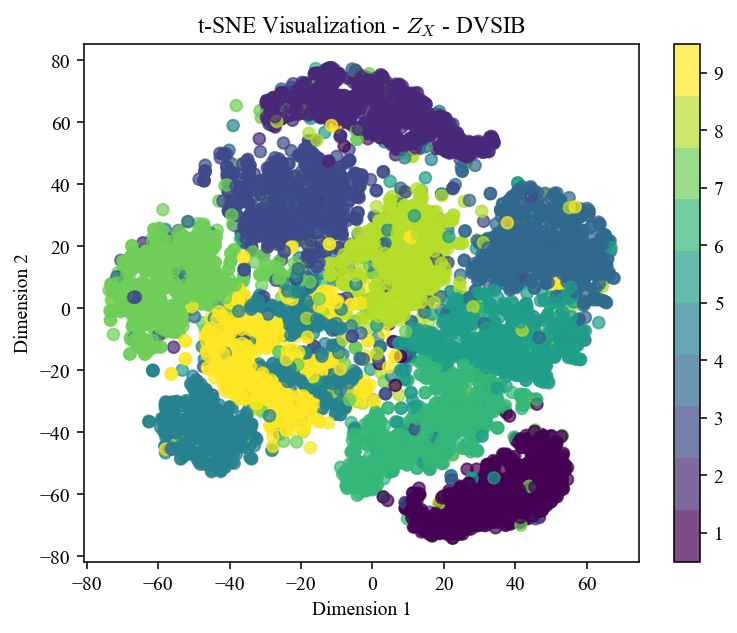

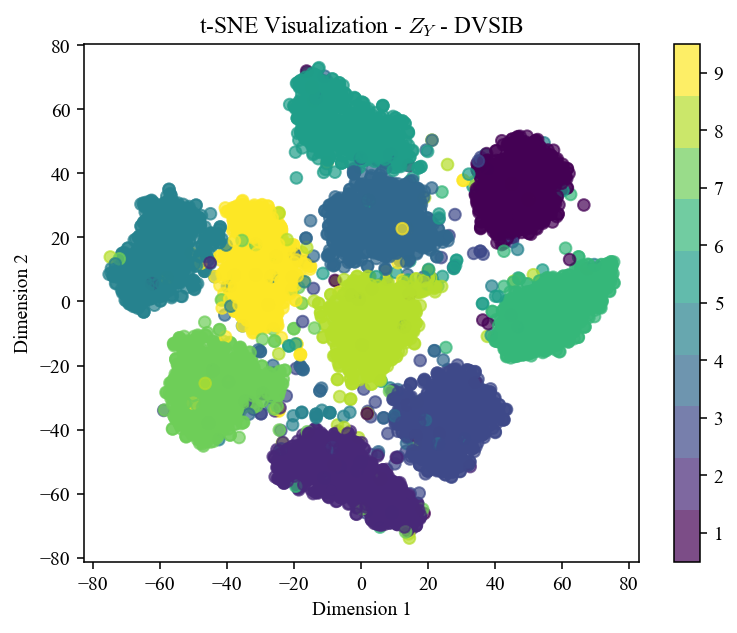

In [22]:
tsne_plot(tsne_result_x, r"$Z_X$ - DVSIB")
tsne_plot(tsne_result_y, r"$Z_Y$ - DVSIB")

In [24]:
# Pass through the encoder to get samples of zx and zy and detach from cpu, ztr is Z from training data, while zctr is Z from training on CPU
with torch.no_grad():
    _,_,szxv = dvsib.ZXencode(val_X)
    _,_,szyv = dvsib.ZYencode(val_Y)
    
    # Calculate the MI between Zx and Zy
    print('I(zx,zy) = ',dvsib.infoZXZY(szxv,szyv).item())


    rx = dvsib.Xdecode(szxv)
    ry = dvsib.Ydecode(szyv)

I(zx,zy) =  1.6684246063232422


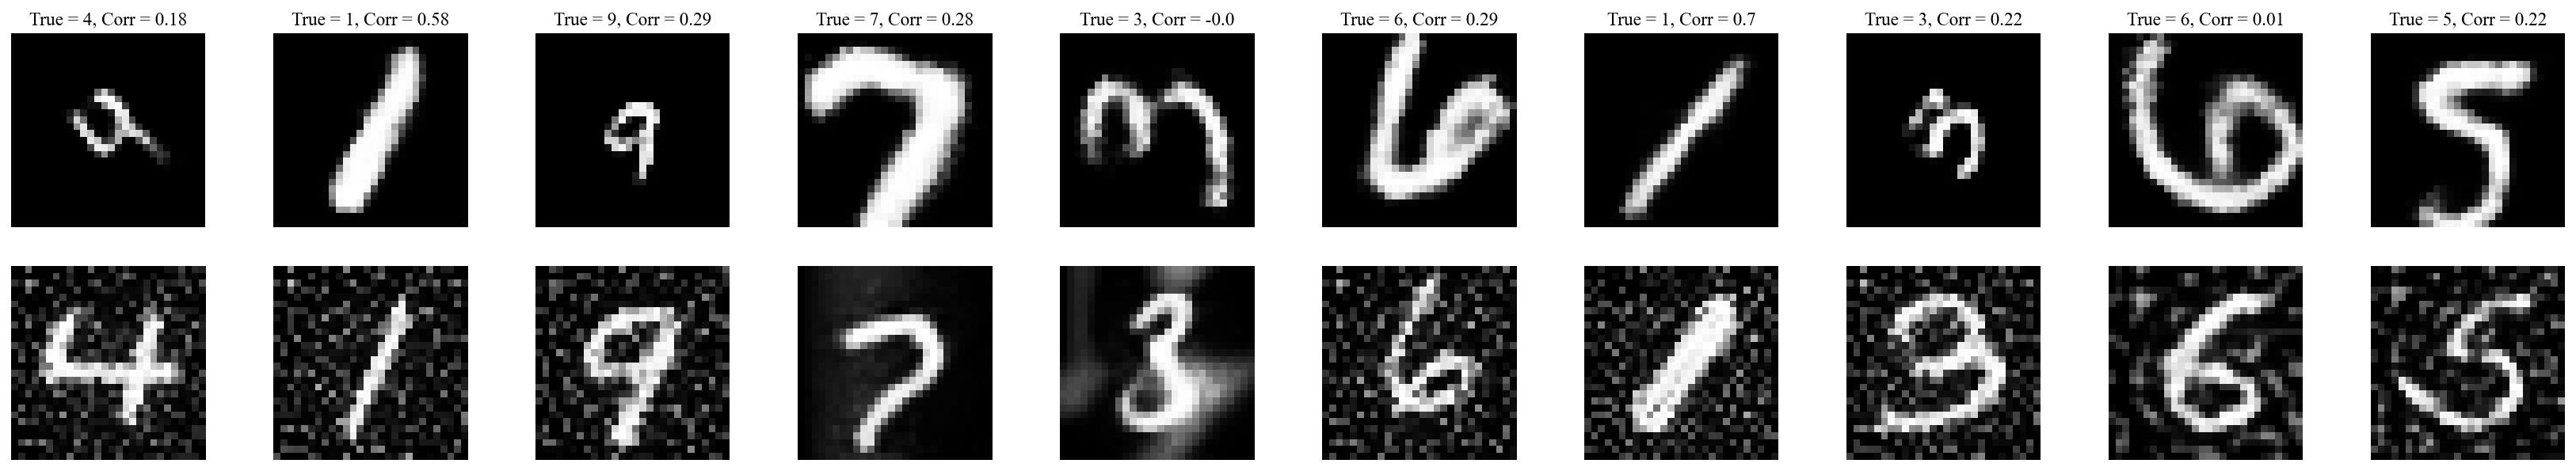

In [25]:
plot_samples(rx.to('cpu').detach(), ry.to('cpu').detach(), val_labels, 10)

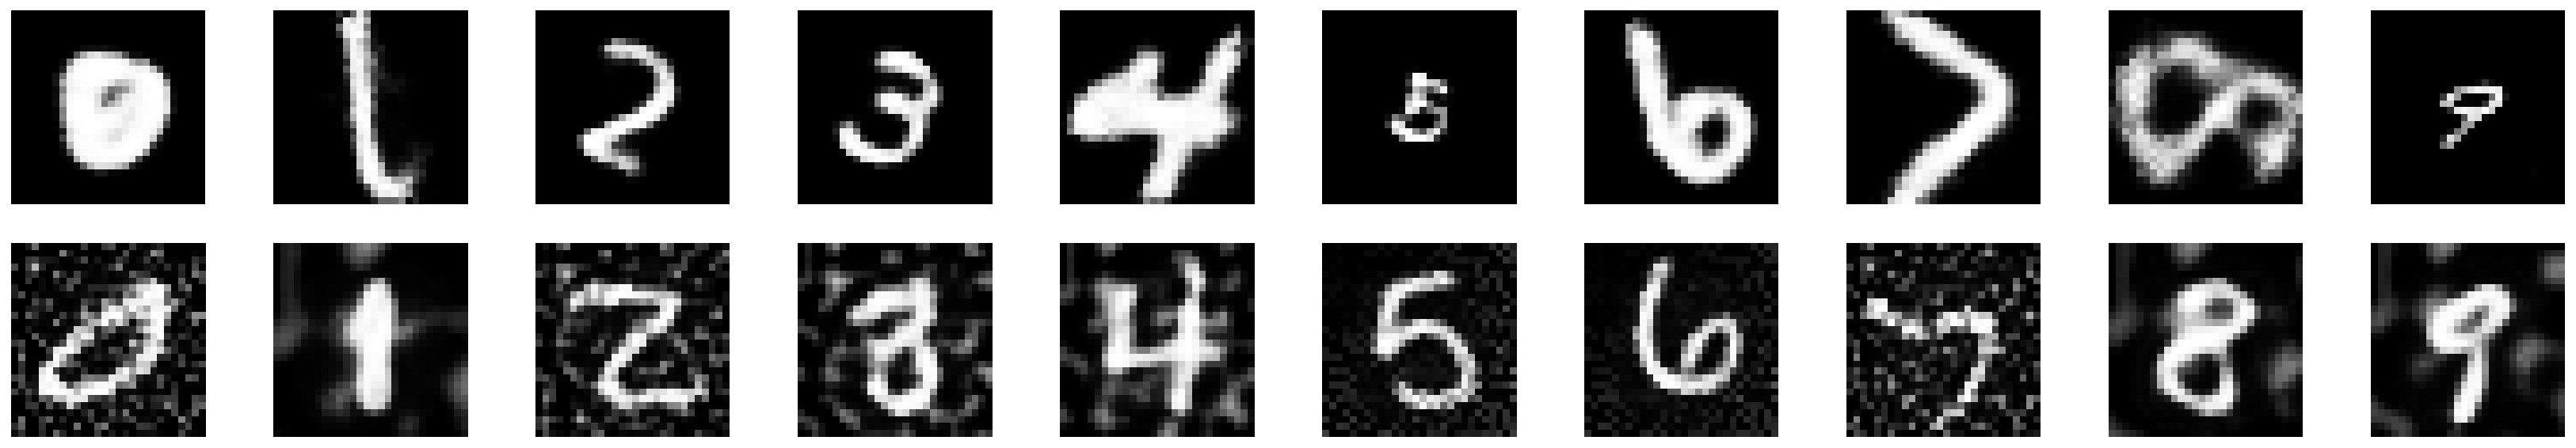

In [29]:
plot_samples1(rx.to('cpu').detach(), ry.to('cpu').detach(), val_labels, 'recon_figures_DVSIB.pdf', 10, 4)

# Part 3: Evaluating Classification Accuracy
Here we investigate how our embeddings that we trained without the labels actually capture the true identity of the labels

We do so as the following, we use the embedings from training to train the model, from testing to either early stop the training or to choose the best classifier, from validation to report the final accuracy:
1. Train a linear SVM with certain slack parameter C and find the accuracy report
2. Perform a GridSearch for different C values to find the optimal C and report its accuracy
3. Train a feed forward neural networks classifiers to match the embeddings with the labels (in one hot encoded form)

# Part 3: Evaluating Classification Accuracy

In this section, we assess how well the embeddings, trained without the use of labels, capture the true identity of the labels. To do this, we employ the following evaluation process, we train a model using training data embeddings, then we either choose the optimal model (in case of SVM) or early stop the training (in case of Neural Networks) using the test data embeddings, then use the validation embeddings to report the accuracy.

We train the following:

**Linear SVM Classification:** We start by training a linear Support Vector Machine (SVM) classifier using the embeddings from the training data for a specific slack parameters (C), and report the classification accuracy.

**GridSearch for Optimal C:** To identify the optimal slack parameter (C) for our linear SVM classifier, we perform a GridSearch. This exhaustive search for various C values allows us to determine the parameter that yields the highest accuracy.

**Feed Forward Neural Networks:** In addition to linear SVM classification, we train feed-forward neural network classifiers. These classifiers are designed to learn complex patterns within the embeddings and labels (one-hot encoded). We evaluate the classification accuracy achieved by these neural networks.

By examining these classification results, we gain insights into the effectiveness of our embeddings for capturing meaningful information. This evaluation helps us understand the practical utility of the embeddings in various downstream tasks, such as classification and prediction.

In [16]:
# Train a single SVM Classifier

# Run an SVM classifier to asses the quality of the representations
clfx = svm.LinearSVC(C=1)
clfy = svm.LinearSVC(C=1)

# Train the classifier on your training data
clfx.fit(zxctr, tr_labels)
clfy.fit(zyctr, tr_labels)

# Make predictions on the testing data
predictionsx = clfx.predict(zxcv)
predictionsy = clfy.predict(zycv)

# Calculate accuracy
accuracyx = accuracy_score(val_labels, predictionsx)
accuracyy = accuracy_score(val_labels, predictionsy)
print("Accuracy_x:", round(accuracyx,3), "Accuracy_y", round(accuracyy,3))

# Generate a classification report for more detailed metrics
print(classification_report(val_labels, predictionsx))
print(classification_report(val_labels, predictionsy))

Accuracy_x: 0.907 Accuracy_y 0.963
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       657
           1       0.97      0.97      0.97       824
           2       0.88      0.90      0.89       681
           3       0.90      0.90      0.90       708
           4       0.90      0.88      0.89       679
           5       0.88      0.85      0.87       688
           6       0.90      0.92      0.91       632
           7       0.93      0.90      0.91       747
           8       0.87      0.89      0.88       710
           9       0.88      0.87      0.88       682

    accuracy                           0.91      7008
   macro avg       0.91      0.91      0.91      7008
weighted avg       0.91      0.91      0.91      7008

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       657
           1       0.98      0.99      0.99       824
           2       0.96      0.97      0.96

In [ ]:
# Doing a gridsearch across multiple C Values:

# Specify the split to always compare to the test data
split_index = [-1]*len(zxctr) + [0]*len(zxcts)
zxdata_con = np.concatenate((zxctr, zxcts), axis=0)
zydata_con = np.concatenate((zyctr, zycts), axis=0)
lbls_con = np.concatenate((tr_labels, ts_labels), axis=0)
pds = PredefinedSplit(test_fold = split_index)

# Define the parameter grid for the SVM classifier C
param_grid = {'C': list(np.logspace(-3,2,11))} 

# Create a GridSearchCV instance for the first classifier (clfx)
grid_search_x = GridSearchCV(svm.LinearSVC(), param_grid, cv=pds, n_jobs=-1)  
grid_search_x.fit(zxdata_con, lbls_con)

# Get the best SVM classifier with optimized hyperparameters
best_clfx = grid_search_x.best_estimator_

# Train the best classifier on your training data
best_clfx.fit(zxdata_con, lbls_con)

# Make predictions on the validating data
predictionsx = best_clfx.predict(zxcv)

# Calculate accuracy
accuracyx = accuracy_score(val_labels, predictionsx)
print("Best Accuracy_x:", round(accuracyx, 3))
print("Optimal C_x value:", best_clfx.C)

# Generate a classification report for more detailed metrics
print(classification_report(val_labels, predictionsx))

# Repeat the same process for the second classifier (clfy)
grid_search_y = GridSearchCV(svm.LinearSVC(), param_grid, cv=pds, n_jobs=-1) 
grid_search_y.fit(zydata_con, lbls_con)

best_clfy = grid_search_y.best_estimator_
best_clfy.fit(zydata_con, lbls_con)
predictionsy = best_clfy.predict(zycv)

# Calculate accuracy
accuracyy = accuracy_score(val_labels, predictionsy)
print("Best Accuracy_y:", round(accuracyy, 3))
print("Optimal C_y value:", best_clfy.C)

# Generate a classification report for more detailed metrics
print(classification_report(val_labels, predictionsy))

In [16]:
# Define a neural network model to classify the data, we use one hot encoding and a softmax layer to output probabilities
class CLASSIFIER(nn.Module):
    def __init__(self, dz):
        super(CLASSIFIER, self).__init__()
        self.dz = dz
        self.fc1 = nn.Linear(dz, 1024)
        # self.fc2 = nn.Linear(1024, 1024) #Extra layer if needed
        # self.dropout = nn.Dropout(0.2) #Dropoutif needed
        self.fc2 = nn.Linear(1024, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


def train_CLASSIFIER(clsf, train_loader, test_loader, num_epochs=20, patience=3, tolerance=1e-3):
    # Choose a loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(clsf.parameters(), lr=0.001)

    best_accuracy = 0.0  # Track the best accuracy
    no_improvement_count = 0  # Track epochs with no improvement

    for epoch in range(num_epochs):
        clsf.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = clsf(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

        # Validation
        clsf.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = clsf(inputs)
                _, predicted = torch.max(outputs, 1)
                _, actual = torch.max(labels, 1)
                total += labels.size(0)
                correct += (predicted == actual).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Accuracy: {accuracy:.2f}%")

        # Check for early stopping
        if accuracy - best_accuracy > tolerance:
            best_accuracy = accuracy
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print("Early stopping: No improvement for {} epochs.".format(patience))
            break

    return clsf, best_accuracy

class Dataset_clsf(torch.utils.data.Dataset):
  def __init__(self, X, labels):
        self.X = X
        self.labels = labels

  def __len__(self):
        return len(self.X)

  def __getitem__(self, index):
        return self.X[index], self.labels[index]

In [17]:
# Set up validate and test loaders for X and Y
# Make the labels into one hot encoded
enc = OneHotEncoder(sparse_output=False)
#enc = OneHotEncoder(sparse=False)

# For X
val_loader_x = DataLoader(Dataset_clsf(zxcv, enc.fit_transform(np.array(val_labels).reshape(-1, 1))) ,batch_size=128, shuffle=True)
tr_loader_x = DataLoader(Dataset_clsf(zxctr, enc.fit_transform(np.array(tr_labels).reshape(-1, 1))) ,batch_size=128, shuffle=True)

# For Y
val_loader_y = DataLoader(Dataset_clsf(zycv, enc.fit_transform(np.array(val_labels).reshape(-1, 1))) ,batch_size=128, shuffle=True)
tr_loader_y = DataLoader(Dataset_clsf(zyctr, enc.fit_transform(np.array(tr_labels).reshape(-1, 1))) ,batch_size=128, shuffle=True)


# Train and Evaluate for X and Y
clsf_x = CLASSIFIER(dz=256).to(device) # GPU
clsf_x, accuracyx_nn = train_CLASSIFIER(clsf_x, tr_loader_x, val_loader_x, num_epochs=20, patience=5, tolerance=1e-4)
print('Best_nn_accuracyx',round(accuracyx_nn,3))

clsf_y = CLASSIFIER(dz=256).to(device) # GPU
clsf_y, accuracyy_nn = train_CLASSIFIER(clsf_y, tr_loader_y, val_loader_y, num_epochs=20, patience=5, tolerance=1e-4)
print('Best_nn_accuracyy',round(accuracyy_nn,3))


Epoch [1/20] - Accuracy: 74.51%
Epoch [2/20] - Accuracy: 75.83%
Epoch [3/20] - Accuracy: 76.48%
Epoch [4/20] - Accuracy: 77.33%
Epoch [5/20] - Accuracy: 76.95%
Epoch [6/20] - Accuracy: 77.94%
Epoch [7/20] - Accuracy: 78.30%
Epoch [8/20] - Accuracy: 78.98%
Epoch [9/20] - Accuracy: 79.89%
Epoch [10/20] - Accuracy: 80.09%
Epoch [11/20] - Accuracy: 79.74%
Epoch [12/20] - Accuracy: 79.79%
Epoch [13/20] - Accuracy: 80.09%
Epoch [14/20] - Accuracy: 80.88%
Epoch [15/20] - Accuracy: 80.94%
Epoch [16/20] - Accuracy: 80.69%
Epoch [17/20] - Accuracy: 81.06%
Epoch [18/20] - Accuracy: 80.51%
Epoch [19/20] - Accuracy: 80.88%
Epoch [20/20] - Accuracy: 80.82%
Best_nn_accuracyx 81.064
Epoch [1/20] - Accuracy: 83.80%
Epoch [2/20] - Accuracy: 85.87%
Epoch [3/20] - Accuracy: 86.59%
Epoch [4/20] - Accuracy: 86.19%
Epoch [5/20] - Accuracy: 86.14%
Epoch [6/20] - Accuracy: 86.62%
Epoch [7/20] - Accuracy: 87.23%
Epoch [8/20] - Accuracy: 87.46%
Epoch [9/20] - Accuracy: 87.30%
Epoch [10/20] - Accuracy: 87.29%
Epo